In [2]:
#%%jupyter_template init
from jupyter_template import magic
magic.init(lambda _=globals: _())

In [3]:
%%jupyter_template code_exec
meta_data_filename = "{{ FileField(name='meta_data_filename', label='Meta data file (.csv or .tsv)', default='metadata_GSE147507_series1.csv', description='Upload metadata as two-column csv format. One column contains sample ids and the other column contains sample labels').value }}"
rnaseq_data_filename = "{{ FileField(name='rnaseq_data_filename', label='RNA-seq data file (.csv or .tsv) ', default='GSE147507_RawReadCounts_Human.csv', description='Upload rna-seq dataset as csv format. The index of the dataset are genes, the columns are samples.').value }}"

meta_class_column_name = "{{ StringField(name='meta_class_column_name', label='Class column name in metadata', default='CLASS', description='class column name of metadata').value }}"
meta_id_column_name = "{{ StringField(name='meta_id_column_name', label='Sample ID column name in metadata', default='SAMPLE_ID', description='sample ID column name of metadata').value }}"

filter_genes = {{ BoolField(name='filter_genes', label='Filtering genes', default='true', description='Check if User wants the dataset to be log-transformed').value }}
low_expression_threshold = {{ FloatField(name='low_expression_threshold', label='Low expression threshold', default='0.3', description='Threshold to filter out low expression genes. The value should vary based on the user dataset.').value }}

logCPM_normalization = {{ BoolField(name='logCPM_normalization', label='logCPM normalization', default='true', description='Check if User wants the dataset to be logCPM-transformed').value }}
log_normalization = {{ BoolField(name='log_normalization', label='log normalization', default='false', description='Check if User wants the dataset to be log-transformed').value }}
z_normalization = {{ BoolField(name='z_normalization', label='z normalization', default='true', description='Check if User wants the dataset to be normalized with Z-normalized method').value }}
q_normalization = {{ BoolField(name='q_normalization', label='q normalization', default='false', description='Check if User wants the dataset to be normalized with Quantile normalization method').value }}

nr_genes = {{ IntField(name='nr_genes', label='the number of genes for PCA', default=2500, description='The maximum number of genes discovered by the Characteristic Direction method').value }}
clustering_topk = {{ IntField(name='clustering_topk', label='the number of genes for clustering', default=800, description='The number of genes with largest variance for Clustergrammer').value }}
gene_topk = {{ IntField(name='gene_topk', label='the maximum number of genes for Enrichr analysis', default=500, description='The maximum number of genes discovered by the Characteristic Direction method').value }}
l1000_topk = {{ IntField(name='l1000_topk', label='the number of genes for L1000CDS2 and L1000FWD', default=500, description='The number of genes to be queried to L1000CDS2').value }}
nr_drugs = {{ IntField(name='nr_drugs', label='the number of result drugs', default=7, description='the number of result drugs').value }}
nr_genesets = {{ IntField(name='nr_genesets', label='the number of result genesets', default=15, description='the number of result gene sets').value }}


pvalue_threshold = {{ FloatField(name='pvalue_threshold', label='pvalue threshold', default='0.05', description='Threshold to highlight significantly differentially expressed genes.').value }}
logfc_threshold = {{ FloatField(name='logfc_threshold', label='logFC threshold', default='1.5', description='Threshold to highlight diffentially expressed genes.').value }}

diff_gex_method = "{{ ChoiceField(name='diff_gex_method',label='diff_gex_method',choices={'limma': 'limma','characteristic_direction': 'characteristic_direction'},default='limma', description='Set a method to get differentially expressed genes').value }}"
interactive_plot = {{ BoolField(name='interactive_plot', label='interactive_plot', default='true', description='Check if User wants interactive plots').value }}


```python
meta_data_filename = "metadata_GSE147507_series1.csv"
rnaseq_data_filename = "GSE147507_RawReadCounts_Human.csv"
meta_class_column_name = "CLASS"
meta_id_column_name = "SAMPLE_ID"
filter_genes = True
low_expression_threshold = 0.3
logCPM_normalization = True
log_normalization = False
z_normalization = True
q_normalization = False
nr_genes = 2500
clustering_topk = 800
gene_topk = 500
l1000_topk = 500
nr_drugs = 7
nr_genesets = 15
pvalue_threshold = 0.05
logfc_threshold = 1.5
diff_gex_method = "limma"
interactive_plot = True
```

In [4]:
interactive_plot = False

In [5]:
import pandas as pd
import os
import urllib3
import requests, json
import sys
import geode

import plotly
from plotly import tools
import plotly.express as px
import plotly.graph_objs as go
plotly.offline.init_notebook_mode() # To embed plots in the output cell of the notebook

import matplotlib.pyplot as plt; plt.rcdefaults()
from matplotlib import rcParams
from matplotlib.lines import Line2D
from matplotlib_venn import venn2, venn3
%matplotlib inline

import IPython
from IPython.display import HTML, display, Markdown, IFrame

from itertools import combinations

import scipy.spatial.distance as dist
import scipy.stats as ss

from sklearn.decomposition import PCA
from sklearn.preprocessing import quantile_transform

import random
from time import sleep
import time
import numpy as np

import warnings
warnings.filterwarnings('ignore')
random.seed(0)

from rpy2 import robjects
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
if interactive_plot == True:
    plot_type='interactive'
else:
    plot_type='static'
    
import chart_studio
import chart_studio.plotly as py
chart_studio.tools.set_credentials_file(username='mjjeon', api_key='v0rpMa6lhST28Sq7XqtM')

results = {}

# 1. Load datasets

In [6]:
if rnaseq_data_filename.endswith(".csv"):
    expr_df = pd.read_csv(rnaseq_data_filename, index_col=0).sort_index()
else:
    expr_df = pd.read_csv(rnaseq_data_filename, index_col=0, sep="\t").sort_index()
if meta_data_filename.endswith(".csv"):
    meta_df = pd.read_csv(meta_data_filename)
else:
    meta_df = pd.read_csv(meta_data_filename, sep="\t")
    
# Match samples between the metadata and the datasets
meta_df = meta_df[meta_df[meta_id_column_name].isin(expr_df.columns)]
expr_df = expr_df.loc[:,meta_df[meta_id_column_name]]

assert(meta_df.shape[0]==expr_df.shape[1])


Filter out low expressed genes 

In [7]:
## Filter out non-expressed genes
expr_df = expr_df.loc[expr_df.sum(axis=1) > 0, :]
print (expr_df.shape)

if filter_genes == True: 
    ## Filter out lowly expressed genes
    mask_low_vals = (expr_df > low_expression_threshold).sum(axis=1) > 2
    expr_df = expr_df.loc[mask_low_vals, :]

    print (expr_df.shape)
dataset = dict()
dataset['rawdata'] = expr_df
dataset['dataset_metadata'] = meta_df

(16360, 6)
(14795, 6)


Normalization

In [8]:
def CPM(data):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = (data/data.sum())*10**6
        data = data.fillna(0)
        
    return data

In [9]:
def logCPM(data):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = (data/data.sum())*10**6
        data = data.fillna(0)
        data = np.log10(data+1)

    # Return
    return data

In [10]:
def log(data):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = data.fillna(0)
        data = np.log10(data+1)

    # Return
    return data

In [11]:
def qnormalization(data):
    newdata = pd.DataFrame(quantile_transform(
        data, axis=1, output_distribution='normal'))
    newdata.columns = data.columns
    newdata.index = data.index
    return newdata

In [12]:
normalization = 'rawdata'
if logCPM_normalization == True:  
    data = dataset[normalization]
    normalization += '+logCPM'
    dataset[normalization] = logCPM(data)
    
if log_normalization == True:    
    data = dataset[normalization]
    normalization += '+log'
    dataset[normalization] = log(data)
    
if z_normalization == True:
    data = dataset[normalization]
    normalization += '+z_norm'    
    dataset[normalization] = data.T.apply(ss.zscore, axis=0).T.dropna()
if q_normalization == True:
    data = dataset[normalization]
    normalization += '+q_norm'
    dataset[normalization] = qnormalization(data)

Display datasets

In [13]:
display(expr_df.head())

Series1_NHBE_Mock_1  Series1_NHBE_Mock_2  Series1_NHBE_Mock_3  \
A1BG                        8                    7                    6   
A1BG-AS1                   23                   34                   33   
A2M                         2                    2                    0   
A2M-AS1                     3                    3                    0   
A2ML1                    1487                 1267                 2156   

          Series1_NHBE_SARS-CoV-2_1  Series1_NHBE_SARS-CoV-2_2  \
A1BG                              7                          3   
A1BG-AS1                         28                         18   
A2M                               1                          0   
A2M-AS1                           1                          0   
A2ML1                          1259                       1280   

          Series1_NHBE_SARS-CoV-2_3  
A1BG                             22  
A1BG-AS1                         68  
A2M                               8  
A2M-AS1                          12  
A2ML1                          5239

In [14]:
display(meta_df.head())

GEO_ID                  SAMPLE_ID                    CLASS
0  GSM4432378        Series1_NHBE_Mock_1        Series1_NHBE_Mock
1  GSM4432379        Series1_NHBE_Mock_2        Series1_NHBE_Mock
2  GSM4432380        Series1_NHBE_Mock_3        Series1_NHBE_Mock
3  GSM4432381  Series1_NHBE_SARS-CoV-2_1  Series1_NHBE_SARS-CoV-2
4  GSM4432382  Series1_NHBE_SARS-CoV-2_2  Series1_NHBE_SARS-CoV-2

In [15]:
display(meta_df.groupby(meta_class_column_name).count())

GEO_ID  SAMPLE_ID
CLASS                                     
Series1_NHBE_Mock             3          3
Series1_NHBE_SARS-CoV-2       3          3

# 2. PCA

Principal Component Analysis (PCA) is a statistical technique used to identify global patterns in high-dimensional datasets. It is commonly used to explore the similarity of biological samples in RNA-seq datasets. To achieve this, gene expression values are transformed into Principal Components (PCs), a set of linearly uncorrelated features which represent the most relevant sources of variance in the data, and subsequently visualized using a scatter plot.

In [16]:
def run_pca(dataset, normalization='logCPM', nr_genes=2500, color_by='auto', color_type='categorical', filter_samples=True, plot_type='interactive'):
    # Get data
    before_norm = normalization.replace("+z_norm", "").replace("+q_norm", "")
    top_genes = dataset[before_norm].var(axis=1).sort_values(ascending=False)
    
    expression_dataframe = dataset[normalization].copy()
    
    # Filter columns
    if filter_samples and dataset.get('signature_metadata'):
        selected_samples = [sample for samples in list(dataset['signature_metadata'].values())[0].values() for sample in samples]
        expression_dataframe = expression_dataframe[selected_samples]

    # Filter rows
    expression_dataframe = expression_dataframe.loc[top_genes.index[:nr_genes]]
    
    # Run PCA
    pca=PCA(n_components=3)
    pca.fit(expression_dataframe)

    # Get Variance
    var_explained = ['PC'+str((i+1))+'('+str(round(e*100, 1))+'% var. explained)' for i, e in enumerate(pca.explained_variance_ratio_)]

    # Estimate colors
    if color_by == 'auto':

        # Add signature groups
        if dataset.get('signature_metadata'):
            A_label, B_label = list(dataset.get('signature_metadata').keys())[0].split(' vs ')
            col = []
            group_dict = list(dataset.get('signature_metadata').values())[0]
            for gsm in dataset['sample_metadata'].index:
                if gsm in group_dict['A']:
                    col.append(A_label)
                elif gsm in group_dict['B']:
                    col.append(B_label)
                else:
                    col.append('Other')
            dataset['dataset_metadata']['Sample Group'] = col
            color_by = 'Sample Group'
        else:

            # Add group column, if available
            if 'Group' in dataset['dataset_metadata'].columns:
                color_by = 'Group'
            else:
                color_by = None


    # Return
    pca_results = {'pca': pca, 'var_explained': var_explained, 
                   'dataset_metadata': dataset['dataset_metadata'][dataset['dataset_metadata'][meta_id_column_name] == expression_dataframe.columns], 
                   'color_by': color_by, 'color_type': color_type, 'nr_genes': nr_genes, 
                   'normalization': normalization, 'signature_metadata': dataset.get('signature_metadata'), 
                   'plot_type': plot_type}
    return pca_results



def plot_pca(pca_results):
    pca_transformed = pca_results['pca']
    variance_explained = pca_results['var_explained']
    meta_df = pca_results['dataset_metadata']
    
    meta_df['x'] = pca_transformed.components_[0]
    meta_df['y'] = pca_transformed.components_[1]
    meta_df['z'] = pca_transformed.components_[2]

    display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',

                },
              });
            </script>
            '''))

    classes = meta_df[meta_class_column_name].unique().tolist()
    SYMBOLS = ['circle', 'square']

    def r(): return random.randint(0, 255)
    COLORS = ['#%02X%02X%02X' % (r(), r(), r())
                      for i in range(len(classes))]


    data = [] # To collect all Scatter3d instances
    for (cls), meta_df_sub in meta_df.groupby([meta_class_column_name]):
        # Iteratate through samples grouped by class
        display_name = '%s' % (cls)
        # Initiate a Scatter3d instance for each group of samples specifying their coordinates
        # and displaying attributes including color, shape, size and etc.
        trace = go.Scatter3d(
            x = meta_df_sub['x'],
            y = meta_df_sub['y'],
            z = meta_df_sub['z'],

            text=meta_df_sub.index,
            mode='markers',
            marker=dict(
                size=10,
                color=COLORS[classes.index(cls)], # Color by infection status
                opacity=.8,
            ),
            name=display_name,
        )

        data.append(trace)

    # Configs for layout and axes
    layout=dict(height=1000, width=1000, 
                title='3D PCA plot for samples',
                scene=dict(
                    xaxis=dict(title=variance_explained[0]),
                    yaxis=dict(title=variance_explained[1]),
                    zaxis=dict(title=variance_explained[2])
                    )
    )
    fig=dict(data=data, layout=layout)
    if plot_type == "interactive":
        plotly.offline.iplot(fig)
    else:
        py.image.ishow(fig)
        
        


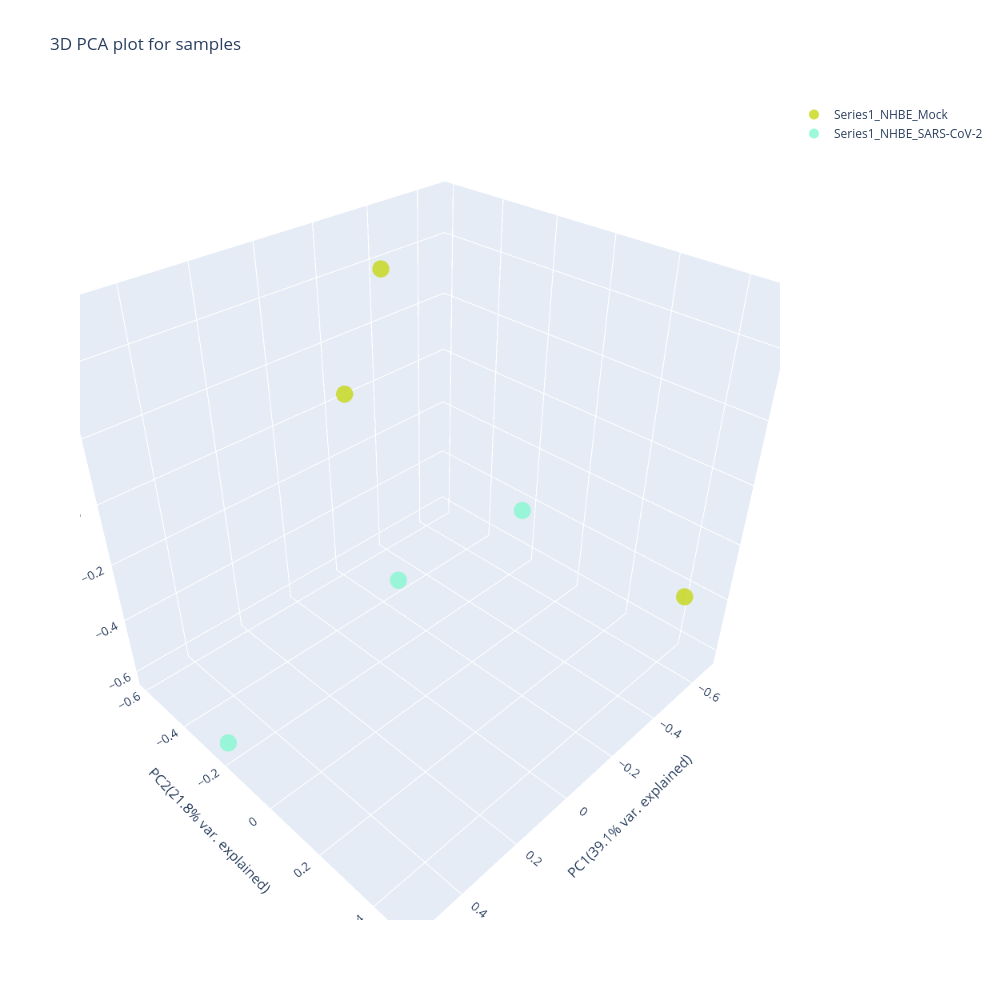

In [17]:
plot_counter = 0
# Run analysis
results['pca'] = run_pca(dataset=dataset, nr_genes=nr_genes, normalization=normalization, plot_type=plot_type)

# Display results
plot_pca(results['pca'])

# 3. Clustergrammar

Clustergrammer is a web-based tool for visualizing and analyzing high-dimensional data as interactive and hierarchically clustered heatmaps. It is commonly used to explore the similarity between samples in an RNA-seq dataset. In addition to identifying clusters of samples, it also allows to identify the genes which contribute to the clustering.

In [18]:
def display_link(url):
    raw_html = '<a href="%s" target="_blank">%s</a>' % (url, url)
    return display(HTML(raw_html))

In [19]:
def run_clustergrammer(dataset, normalization='logCPM', z_score=True, nr_genes=1500, metadata_cols=None, filter_samples=True):
    # Subset the expression DataFrame using top 800 genes with largest variance
    data = dataset[normalization].copy()
    variances = np.var(data, axis=1)
    srt_idx = variances.argsort()[::-1]
    expr_df_sub = data.iloc[srt_idx].iloc[:nr_genes]
    
    # prettify sample names
    sample_names = ['::'.join([y, x]) for x,y in
                       zip(meta_df[meta_class_column_name], expr_df_sub.columns)]
    expr_df_sub.columns = sample_names
    expr_df_sub.index = ["Gene: "+str(x) for x in expr_df_sub.index]
    sample_name = ["Sample: "+x for x in sample_names]
    expr_df_sub.columns = sample_name


    treatment_type = ["Class: "+ x.split("::")[1] for x in sample_names]
    new_series = pd.DataFrame(treatment_type).T
    new_series.columns = expr_df_sub.columns
    expr_df_sub = pd.concat([new_series, expr_df_sub], axis=0)

    index_list = list(expr_df_sub.index)
    index_list = ["" if "Gene" not in str(x) else x for x in index_list]
    expr_df_sub.index = index_list
    expr_df_sub_file = "expr_df_sub_file.txt"
    expr_df_sub.to_csv("expr_df_sub_file.txt", sep='\t')
    # POST the expression matrix to Clustergrammer and get the URL
    clustergrammer_url = 'http://amp.pharm.mssm.edu/clustergrammer/matrix_upload/'

    r = requests.post(clustergrammer_url, files={'file': open(expr_df_sub_file, 'rb')}).text
    return r
    
#############################################
########## 2. Plot
#############################################

def plot_clustergrammar(clustergrammer_url):
    display_link(clustergrammer_url)
    # Embed
    display(IPython.display.IFrame(clustergrammer_url, width="1000", height="1000"))

In [20]:
# Run analysis
results['clustergrammer'] = run_clustergrammer(dataset=dataset, nr_genes=clustering_topk, normalization=normalization, z_score=True)

# Display results
plot_clustergrammar(results['clustergrammer'])

# 4. Library size analysis

In order to quantify gene expression in an RNA-seq dataset, reads generated from the sequencing step are mapped to a reference genome and subsequently aggregated into numeric gene counts. Due to experimental variations and random technical noise, samples in an RNA-seq datasets often have variable amounts of the total RNA. Library size analysis calculates and displays the total number of reads mapped for each sample in the RNA-seq dataset, facilitating the identification of outlying samples and the assessment of the overall quality of the data.

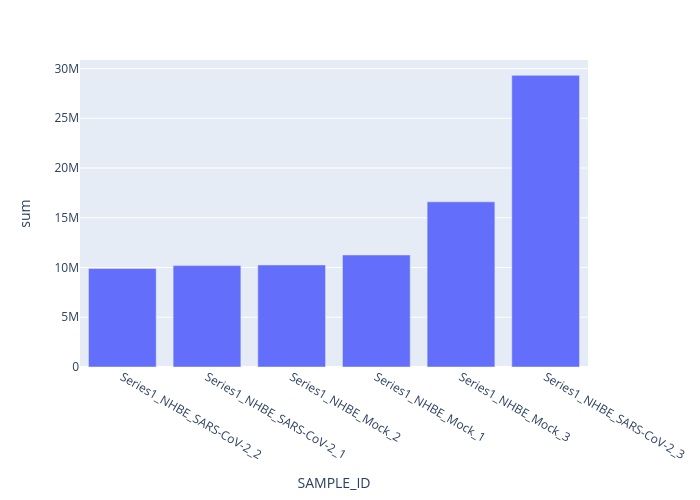

In [21]:
# meta_df['sum'] = [x/10**5 for x in expr_df.sum().tolist()]
meta_df['sum'] = expr_df.sum().tolist()
fig = px.bar(meta_df.sort_values(by='sum'), x="SAMPLE_ID", y='sum')

if plot_type=='interactive':
        plotly.offline.iplot(fig)
else:
    py.image.ishow(fig)

# 5. Differential Gene Expression 

Gene expression signatures are alterations in the patterns of gene expression that occur as a result of cellular perturbations such as drug treatments, gene knock-downs or diseases. They can be quantified using differential gene expression (DGE) methods, which compare gene expression between two groups of samples to identify genes whose expression is significantly altered in the perturbation. 

In [22]:
robjects.r('''limma <- function(rawcount_dataframe, design_dataframe, filter_genes=FALSE, adjust="BH") {
    
    # Load packages
    suppressMessages(require(limma))
    suppressMessages(require(edgeR))

    # Convert design matrix
    design <- as.matrix(design_dataframe)

    # Create DGEList object
    dge <- DGEList(counts=rawcount_dataframe)

    # Filter genes
    if (filter_genes) {
        keep <- filterByExpr(dge, design)
        dge <- dge[keep,]
    }

    # Calculate normalization factors
    dge <- calcNormFactors(dge)

    # Run VOOM
    v <- voom(dge, plot=FALSE)

    # Fit linear model
    fit <- lmFit(v, design)

    # Make contrast matrix
    cont.matrix <- makeContrasts(de=B-A, levels=design)

    # Fit
    fit2 <- contrasts.fit(fit, cont.matrix)

    # Run DE
    fit2 <- eBayes(fit2)

    # Get results
    limma_dataframe <- topTable(fit2, adjust=adjust, number=nrow(rawcount_dataframe))
    limma_dataframe$gene_symbol <- rownames(limma_dataframe)

    # Return
    return(limma_dataframe)
}
''')

R object with classes: ('function',) mapped to:

In [23]:
def get_signatures(classes, dataset):
    expr_df = dataset['rawdata']
    meta_df = dataset["dataset_metadata"]
    signatures = dict()
    for A, B in combinations(classes, 2):
        group_A = meta_df.loc[meta_df[meta_class_column_name]==A, "SAMPLE_ID"].tolist()
        group_B = meta_df.loc[meta_df[meta_class_column_name]==B, "SAMPLE_ID"].tolist()

        design_dataframe = pd.DataFrame([{'index': x, 'A': int(x in group_A), 'B': int(x in group_B)} for x in expr_df.columns]).set_index('index')

        processed_data = {"expression": expr_df, 'design': design_dataframe}

        limma = robjects.r['limma']
        signature = pandas2ri.conversion.rpy2py(limma(pandas2ri.conversion.py2rpy(processed_data['expression']), pandas2ri.conversion.py2rpy(processed_data['design']), filter_genes))

        signature_label = "vs.".join([A, B])
        signatures[signature_label] = signature.sort_values("t", ascending=False)
    return signatures

In [24]:
classes = meta_df[meta_class_column_name].unique().tolist()
signatures = get_signatures(classes, dataset)

In [25]:
for key, signature in signatures.items():
    print(key)
    display(signature)

Series1_NHBE_Mockvs.Series1_NHBE_SARS-CoV-2


logFC   AveExpr          t       P.Value     adj.P.Val          B  \
SAA2     2.416540  4.969976  23.526408  6.124990e-12  7.373876e-08  17.322106   
CCL20    3.129664  4.212113  20.818602  2.835105e-11  1.706592e-07  15.774466   
IL36G    2.747132  3.778895  18.776932  1.025546e-10  4.115516e-07  14.526635   
SPRR2D   3.001008  4.095500  16.763635  4.170066e-10  9.915814e-07  13.441460   
INHBA    1.834116  6.232399  16.664756  4.485122e-10  9.915814e-07  13.629578   
...           ...       ...        ...           ...           ...        ...   
THBD    -0.982626  4.832669  -7.409203  5.517664e-06  8.740415e-04   4.234102   
MXRA5   -0.911260  5.680528  -7.423178  5.408867e-06  8.740415e-04   4.176918   
IFITM10 -1.497352  3.636318  -7.590115  4.271777e-06  7.150031e-04   4.601002   
KRT15   -0.927239  9.548552  -8.157007  1.965457e-06  4.010531e-04   5.102422   
OLFML2A -0.954713  4.873076  -8.238844  1.762557e-06  3.658521e-04   5.395703   

        gene_symbol  
SAA2           SAA2  
CCL20         CCL20  
IL36G         IL36G  
SPRR2D       SPRR2D  
INHBA         INHBA  
...             ...  
THBD           THBD  
MXRA5         MXRA5  
IFITM10     IFITM10  
KRT15         KRT15  
OLFML2A     OLFML2A  

[12039 rows x 7 columns]

# 6. Volcano Plot

Volcano plots are a type of scatter plot commonly used to display the results of a differential gene expression analysis. They can be used to quickly identify genes whose expression is significantly altered in a perturbation, and to assess the global similarity of gene expression in two groups of biological samples. Each point in the scatter plot represents a gene; the axes display the significance versus fold-change estimated by the differential expression analysis.

In [26]:
def plot_2D_scatter(x, y, text='', title='', xlab='', ylab='', hoverinfo='text', color='black', colorscale='Blues', size=8, showscale=False, symmetric_x=False, symmetric_y=False, pad=0.5, hline=False, vline=False, return_trace=False, labels=False, plot_type='interactive', de_type='ma'):
    range_x = [-max(abs(x))-pad, max(abs(x))+pad]if symmetric_x else None
    range_y = [-max(abs(y))-pad, max(abs(y))+pad]if symmetric_y else None
    trace = go.Scattergl(x=x, y=y, mode='markers', text=text, hoverinfo=hoverinfo, marker={'color': color, 'colorscale': colorscale, 'showscale': showscale, 'size': size})
    if return_trace:
        return trace
    else:
        if de_type == 'ma':
            annotations = [
                {'x': 1, 'y': 0.1, 'text':'<span style="color: blue; font-size: 10pt; font-weight: 600;">Down-regulated in '+labels[-1]+'</span>', 'showarrow': False, 'xref': 'paper', 'yref': 'paper', 'xanchor': 'right', 'yanchor': 'top'},
                {'x': 1, 'y': 0.9, 'text':'<span style="color: red; font-size: 10pt; font-weight: 600;">Up-regulated in '+labels[-1]+'</span>', 'showarrow': False, 'xref': 'paper', 'yref': 'paper', 'xanchor': 'right', 'yanchor': 'bottom'}
            ] if labels else []
        elif de_type == 'volcano':
            annotations = [
                {'x': 0.25, 'y': 1.07, 'text':'<span style="color: blue; font-size: 10pt; font-weight: 600;">Down-regulated in '+labels[-1]+'</span>', 'showarrow': False, 'xref': 'paper', 'yref': 'paper', 'xanchor': 'center'},
                {'x': 0.75, 'y': 1.07, 'text':'<span style="color: red; font-size: 10pt; font-weight: 600;">Up-regulated in '+labels[-1]+'</span>', 'showarrow': False, 'xref': 'paper', 'yref': 'paper', 'xanchor': 'center'}
            ] if labels else []
        layout = go.Layout(title=title, xaxis={'title': xlab, 'range': range_x}, yaxis={'title': ylab, 'range': range_y}, hovermode='closest', annotations=annotations)
        fig = go.Figure(data=[trace], layout=layout)
    
    if plot_type=='interactive':
        plotly.offline.iplot(fig)
    else:
        py.image.ishow(fig)

In [27]:
def run_volcano(signatures, dataset, normalization='logCPM'):
    expr_df = dataset['rawdata']
    meta_df = dataset["dataset_metadata"]
#     signatures = dict()
    for signature_label, signature in signatures.items():
#     for A, B in combinations(classes, 2):
#         group_A = meta_df.loc[meta_df[meta_class_column_name]==A, "SAMPLE_ID"].tolist()
#         group_B = meta_df.loc[meta_df[meta_class_column_name]==B, "SAMPLE_ID"].tolist()

#         design_dataframe = pd.DataFrame([{'index': x, 'A': int(x in group_A), 'B': int(x in group_B)} for x in expr_df.columns]).set_index('index')

#         processed_data = {"expression": expr_df, 'design': design_dataframe}

#         limma = robjects.r['limma']
#         signature = pandas2ri.conversion.rpy2py(limma(pandas2ri.conversion.py2rpy(processed_data['expression']), pandas2ri.conversion.py2rpy(processed_data['design']), filter_genes))

#         signature_label = "vs.".join([A, B])
#         signatures[signature_label] = signature
        # Loop through signature
        color = []
        text = []
        for index, rowData in signature.iterrows():

            # Text
            text.append('<b>'+index+'</b><br>Avg Expression = '+str(round(rowData['AveExpr'], ndigits=2))+'<br>logFC = '+str(round(rowData['logFC'], ndigits=2))+'<br>p = '+'{:.2e}'.format(rowData['P.Value'])+'<br>FDR = '+'{:.2e}'.format(rowData['adj.P.Val']))

            # Color
            if rowData['P.Value'] < pvalue_threshold:
                if rowData['logFC'] < -logfc_threshold:
                    color.append('blue')
                elif rowData['logFC'] > logfc_threshold:
                    color.append('red')
                else:
                    color.append('black')

            else:
                color.append('black')

    volcano_plot_results = {'x': signature['logFC'], 'y': -np.log10(signature['P.Value']), 'text':text, 'color': color, 'signature_label': signature_label, 'plot_type': plot_type}
    return volcano_plot_results

def plot_volcano(volcano_plot_results):
    spacer = ' '*50
    plot_2D_scatter(
        x=volcano_plot_results['x'],
        y=volcano_plot_results['y'],
        text=volcano_plot_results['text'],
        color=volcano_plot_results['color'],
        symmetric_x=True,
        xlab='log2FC',
        ylab='-log10P',
        title='<b>{volcano_plot_results[signature_label]} Signature | Volcano Plot</b>'.format(**locals()),
        labels=volcano_plot_results['signature_label'].split('vs.'),
        plot_type=volcano_plot_results['plot_type'],
        de_type='volcano'
    )

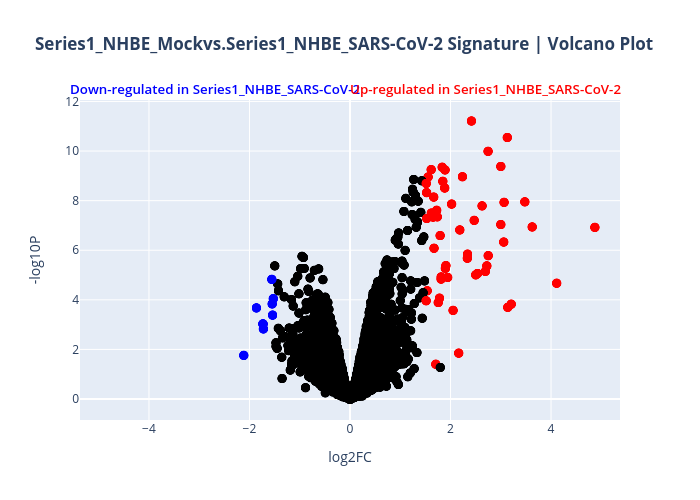

In [28]:
  
volcano_plot_results = run_volcano(signatures, dataset)
plot_volcano(volcano_plot_results)

# 7. MA Plot

MA plots are a type of scatter plot commonly used to display the results of a differential gene expression analysis. They can be used to quickly identify genes whose expression is significantly altered in a perturbation, and to assess the global similarity of gene expression in two groups of biological samples. Each point in the scatter plot represents a gene; the axes display the average gene expression versus fold-change estimated by the differential expression analysis.

In [29]:
def run_maplot(signature, signature_label='', pvalue_threshold=0.05, logfc_threshold=1.5, plot_type='interactive'):

    # Loop through signature
    color = []
    text = []
    for index, rowData in signature.iterrows():

        # Text
        text.append('<b>'+index+'</b><br>Avg Expression = '+str(round(rowData['AveExpr'], ndigits=2))+'<br>logFC = '+str(round(rowData['logFC'], ndigits=2))+'<br>p = '+'{:.2e}'.format(rowData['P.Value'])+'<br>FDR = '+'{:.2e}'.format(rowData['adj.P.Val']))

        # Color
        if rowData['adj.P.Val'] < pvalue_threshold:
            if rowData['logFC'] < -logfc_threshold:
                color.append('blue')
            elif rowData['logFC'] > logfc_threshold:
                color.append('red')
            else:
                color.append('black')

        else:
            color.append('black')
    
    # Return 
    volcano_plot_results = {'x': signature['AveExpr'], 'y': signature['logFC'], 'text':text, 'color': color, 'signature_label': signature_label, 'plot_type': plot_type}
    return volcano_plot_results

def plot_maplot(volcano_plot_results):    
    plot_2D_scatter(
        x=volcano_plot_results['x'],
        y=volcano_plot_results['y'],
        text=volcano_plot_results['text'],
        color=volcano_plot_results['color'],
        symmetric_y=True,
        xlab='Average Expression',
        ylab='logFC',
        title='<b>{volcano_plot_results[signature_label]} Signature | MA Plot</b>'.format(**locals()),
        labels=volcano_plot_results['signature_label'].split('vs.'),
        plot_type=volcano_plot_results['plot_type']
    )

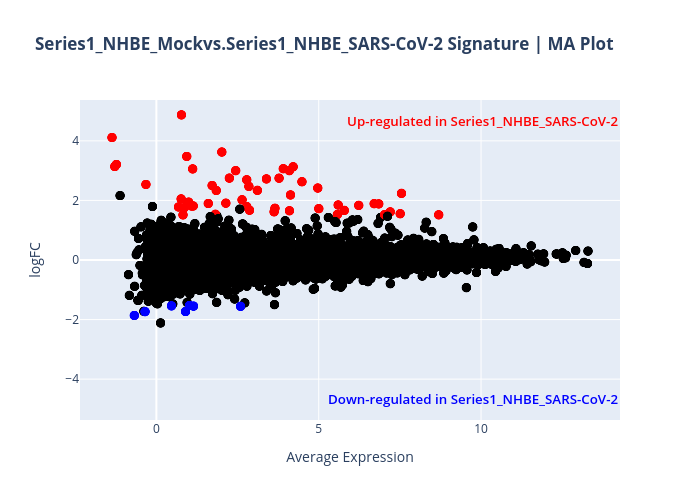

In [30]:
# Initialize results
results['ma_plot'] = {}

# Loop through signatures
for label, signature in signatures.items():

    # Run analysis
    results['ma_plot'][label] = run_maplot(signature=signature, signature_label=label, pvalue_threshold=pvalue_threshold, logfc_threshold=logfc_threshold, plot_type=plot_type)

    # Display results
    plot_maplot(results['ma_plot'][label])

# 8. Enrichr

Enrichment analysis is a statistical procedure used to identify biological terms which are over-represented in a given gene set. These include signaling pathways, molecular functions, diseases, and a wide variety of other biological terms obtained by integrating prior knowledge of gene function from multiple resources. Enrichr is a web-based application which allows to perform enrichment analysis using a large collection of gene-set libraries and various interactive approaches to display enrichment results.

In [31]:
def submit_enrichr_geneset(geneset, label=''):
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/addList'
    genes_str = '\n'.join(geneset)
    payload = {
        'list': (None, genes_str),
        'description': (None, label)
    }
    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')
    time.sleep(0.5)
    data = json.loads(response.text)
    return data

def run_enrichr(signature, signature_label, geneset_size=500, sort_genes_by='t'):

    # Sort signature
    signature = signature.sort_values(sort_genes_by, ascending=False)

    # Get genesets
    genesets = {
        'upregulated': signature.index[:geneset_size],
        'downregulated': signature.index[-geneset_size:]
    }

    # Submit to Enrichr
    enrichr_ids = {geneset_label: submit_enrichr_geneset(geneset=geneset, label=signature_label+', '+geneset_label+', from BioJupies') for geneset_label, geneset in genesets.items()}
    enrichr_ids['signature_label'] = signature_label
    return enrichr_ids



In [32]:
def run_cd(dataset, normalization):
    meta_df = dataset['dataset_metadata'].copy()
    expr_df = dataset[normalization]
    d_platform_cd = {} # to top up/down genes
    cd_results = dict()

    sample_classes = {}
    for layout1 in meta_df[meta_class_column_name].unique():
        for layout2 in meta_df[meta_class_column_name].unique():
            if layout1 != layout2:            
                sample_class = np.zeros(expr_df.shape[1], dtype=np.int32)
                sample_class[meta_df[meta_class_column_name].values == layout1] = 1
                sample_class[meta_df[meta_class_column_name].values == layout2] = 2
                diff_gene_set_name = "vs.".join([layout1, layout2])
                sample_classes[diff_gene_set_name] = sample_class


    for platform, sample_class in sample_classes.items():

        cd_res = geode.chdir(expr_df.values, sample_class, expr_df.index, gamma=.5, sort=False, calculate_sig=False)
        cd_coefs = np.array([x[0] for x in cd_res])
        cd_coefs_series = pd.DataFrame(cd_coefs)
        cd_coefs_series.index = expr_df.index
        cd_coefs_series.columns = ["coef"]
        cd_results[platform] = cd_coefs_series
        
    return cd_results

if diff_gex_method == "characteristic_direction":
    signatures = run_cd(dataset, normalization)
    sort_genes_by = 'coef'
else:
    sort_genes_by = 't'

In [33]:
# Loop through signatures
results = {}
results['enrichr']= {}

for label, signature in signatures.items():
    # Run analysis
    results['enrichr'][label] = run_enrichr(signature=signature, signature_label=label, geneset_size=gene_topk, sort_genes_by=sort_genes_by)
    print(label+"-up")
    display_link("https://amp.pharm.mssm.edu/Enrichr/enrich?dataset={}".format(results['enrichr'][label]["upregulated"]["shortId"]))
    print(label+"-down")
    display_link("https://amp.pharm.mssm.edu/Enrichr/enrich?dataset={}".format(results['enrichr'][label]["downregulated"]["shortId"]))
    

Series1_NHBE_Mockvs.Series1_NHBE_SARS-CoV-2-up


Series1_NHBE_Mockvs.Series1_NHBE_SARS-CoV-2-down


# 9. GO Enrichment Analysis

Gene Ontology (GO) is a major bioinformatics initiative aimed at unifying the representation of gene attributes across all species. It contains a large collection of experimentally validated and predicted associations between genes and biological terms. This information can be leveraged by Enrichr to identify the biological processes, molecular functions and cellular components which are over-represented in the up-regulated and down-regulated genes identified by comparing two groups of samples.

In [34]:
def get_enrichr_results(user_list_id, gene_set_libraries, overlappingGenes=True, geneset=None):
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
    query_string = '?userListId=%s&backgroundType=%s'
    results = []
    for gene_set_library, label in gene_set_libraries.items():
        response = requests.get(
                    ENRICHR_URL +
                       query_string % (user_list_id, gene_set_library)
                )
        if not response.ok:
            raise Exception('Error fetching enrichment results')

        data = json.loads(response.text)
        resultDataframe = pd.DataFrame(data[gene_set_library], columns=[
                                       'rank', 'term_name', 'pvalue', 'zscore', 'combined_score', 'overlapping_genes', 'FDR', 'old_pvalue', 'old_FDR'])
        selectedColumns = ['term_name', 'zscore', 'combined_score', 'pvalue', 'FDR'] if not overlappingGenes else [
            'term_name', 'zscore', 'combined_score', 'FDR', 'pvalue', 'overlapping_genes']
        resultDataframe = resultDataframe.loc[:, selectedColumns]
        resultDataframe['gene_set_library'] = label
        resultDataframe['log10P'] = -np.log10(resultDataframe['pvalue'])
        results.append(resultDataframe)
    concatenatedDataframe = pd.concat(results)
    if geneset:
        concatenatedDataframe['geneset'] = geneset
    return concatenatedDataframe


def run_go(enrichr_results, signature_label, plot_type='interactive', go_version='2018', sort_results_by='pvalue'):

    # Libraries
    go_version = str(go_version)
    libraries = {
        'GO_Biological_Process_'+go_version: 'Gene Ontology Biological Process ('+go_version+' version)',
        'GO_Molecular_Function_'+go_version: 'Gene Ontology Molecular Function ('+go_version+' version)',
        'GO_Cellular_Component_'+go_version: 'Gene Ontology Cellular Component ('+go_version+' version)'
    }

    # Get Enrichment Results
    enrichment_results = {geneset: get_enrichr_results(enrichr_results[geneset]['userListId'], gene_set_libraries=libraries, geneset=geneset) for geneset in ['upregulated', 'downregulated']}
    enrichment_results['signature_label'] = signature_label
    enrichment_results['plot_type'] = plot_type
    enrichment_results['sort_results_by'] = sort_results_by

    # Return
    return enrichment_results



def plot_library_barchart(enrichr_results, gene_set_library, signature_label, sort_results_by='pvalue', nr_genesets=15, height=400, plot_type='interactive'):
    sort_results_by = 'log10P' if sort_results_by == 'pvalue' else 'combined_score'
    fig = tools.make_subplots(rows=1, cols=2, print_grid=False)
    for i, geneset in enumerate(['upregulated', 'downregulated']):
        # Get dataframe
        enrichment_dataframe = enrichr_results[geneset]
        plot_dataframe = enrichment_dataframe[enrichment_dataframe['gene_set_library'] == gene_set_library].sort_values(sort_results_by, ascending=False).iloc[:nr_genesets].iloc[::-1]

        # Format
        n = 7
        plot_dataframe['nr_genes'] = [len(genes) for genes in plot_dataframe['overlapping_genes']]
        plot_dataframe['overlapping_genes'] = ['<br>'.join([', '.join(genes[i:i+n]) for i in range(0, len(genes), n)]) for genes in plot_dataframe['overlapping_genes']]

        # Get Bar
        bar = go.Bar(
            x=plot_dataframe[sort_results_by],
            y=plot_dataframe['term_name'],
            orientation='h',
            name=geneset.title(),
            showlegend=False,
            hovertext=['<b>{term_name}</b><br><b>P-value</b>: <i>{pvalue:.2}</i><br><b>FDR</b>: <i>{FDR:.2}</i><br><b>Z-score</b>: <i>{zscore:.3}</i><br><b>Combined score</b>: <i>{combined_score:.3}</i><br><b>{nr_genes} Genes</b>: <i>{overlapping_genes}</i><br>'.format(**rowData) for index, rowData in plot_dataframe.iterrows()],
            hoverinfo='text',
            marker={'color': '#FA8072' if geneset == 'upregulated' else '#87CEFA'}
        )
        fig.append_trace(bar, 1, i+1)

        # Get text
        text = go.Scatter(
            x=[max(bar['x'])/50 for x in range(len(bar['y']))],
            y=bar['y'],
            mode='text',
            hoverinfo='none',
            showlegend=False,
            text=['*<b>{}</b>'.format(rowData['term_name']) if rowData['FDR'] < 0.1 else '{}'.format(
                rowData['term_name']) for index, rowData in plot_dataframe.iterrows()],
            textposition="middle right",
            textfont={'color': 'black'}
        )
        fig.append_trace(text, 1, i+1)

    # Get annotations
    labels = signature_label.split('vs.')
    annotations = [
        {'x': 0.25, 'y': 1.06, 'text': '<span style="color: #FA8072; font-size: 10pt; font-weight: 600;">Up-regulated in ' +
            labels[-1]+'</span>', 'showarrow': False, 'xref': 'paper', 'yref': 'paper', 'xanchor': 'center'},
        {'x': 0.75, 'y': 1.06, 'text': '<span style="color: #87CEFA; font-size: 10pt; font-weight: 600;">Down-regulated in ' +
            labels[-1]+'</span>', 'showarrow': False, 'xref': 'paper', 'yref': 'paper', 'xanchor': 'center'}
    ] if signature_label else []

    # Get title
    title = signature_label + ' | ' + gene_set_library

    fig['layout'].update(height=height, title='<b>{}</b>'.format(title),
                         hovermode='closest', annotations=annotations)
    fig['layout']['xaxis1'].update(domain=[0, 0.49], title='-log10P' if sort_results_by == 'log10P' else 'Enrichment score')
    fig['layout']['xaxis2'].update(domain=[0.51, 1], title='-log10P' if sort_results_by == 'log10P' else 'Enrichment score')
    fig['layout']['yaxis1'].update(showticklabels=False)
    fig['layout']['yaxis2'].update(showticklabels=False)
    fig['layout']['margin'].update(l=0, t=65, r=0, b=35)
    if plot_type=='interactive':
        plotly.offline.iplot(fig)
    else:
        py.image.ishow(fig)
    

In [35]:
results['go_enrichment'] = {}
for label, signature in signatures.items():
    # Run analysis
    results['go_enrichment'][label] = run_go(results['enrichr'][label], label)

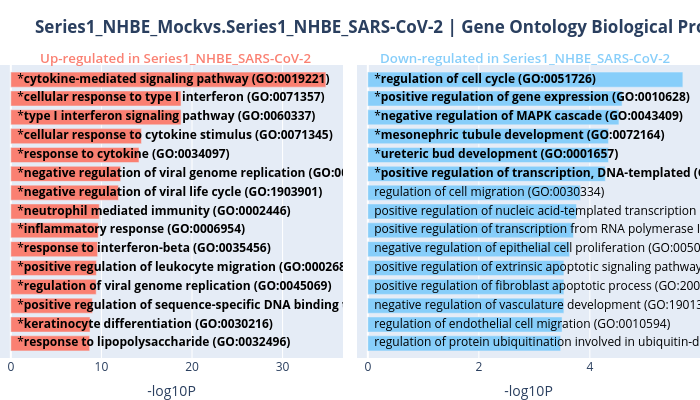

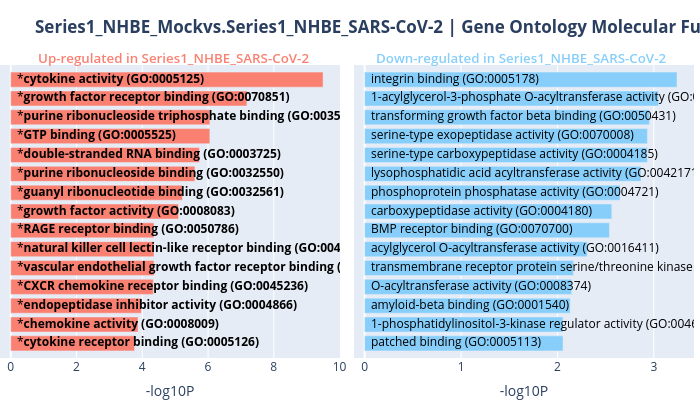

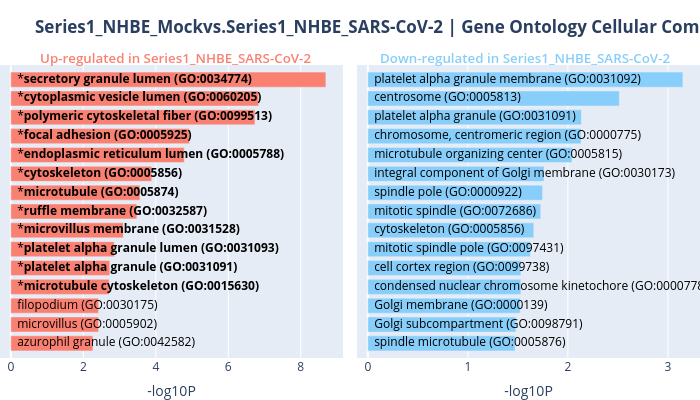

In [36]:
for label, signature in signatures.items():
    # Create dataframe
    enrichment_results = results['go_enrichment'][label]
    enrichment_dataframe = pd.concat([enrichment_results['upregulated'], enrichment_results['downregulated']])

    # Plot barcharts
    libraries = enrichment_dataframe['gene_set_library'].unique()   
    for gene_set_library in libraries:
        plot_library_barchart(enrichment_results, gene_set_library, enrichment_results['signature_label'], enrichment_results['sort_results_by'], nr_genesets=nr_genesets, plot_type=plot_type) # 10 300
    

# 10. Pathway Enrichment Analysis

Biological pathways are sequences of interactions between biochemical compounds which play a key role in determining cellular behavior. Databases such as KEGG, Reactome and WikiPathways contain a large number of associations between such pathways and genes. This information can be leveraged by Enrichr to identify the biological pathways which are over-represented in the up-regulated and down-regulated genes identified by comparing two groups of samples.

In [37]:
def run_pathway(enrichr_results, signature_label, plot_type='interactive', sort_results_by='pvalue'):

    # Libraries
    libraries = {
        'KEGG_2016': 'KEGG Pathways',
        'WikiPathways_2016': 'WikiPathways',
        'Reactome_2016': 'Reactome Pathways'
    }

    # Get Enrichment Results
    enrichment_results = {geneset: get_enrichr_results(enrichr_results[geneset]['userListId'], gene_set_libraries=libraries, geneset=geneset) for geneset in ['upregulated', 'downregulated']}
    enrichment_results['signature_label'] = signature_label
    enrichment_results['plot_type'] = plot_type
    enrichment_results['sort_results_by'] = sort_results_by

    # Return
    return enrichment_results

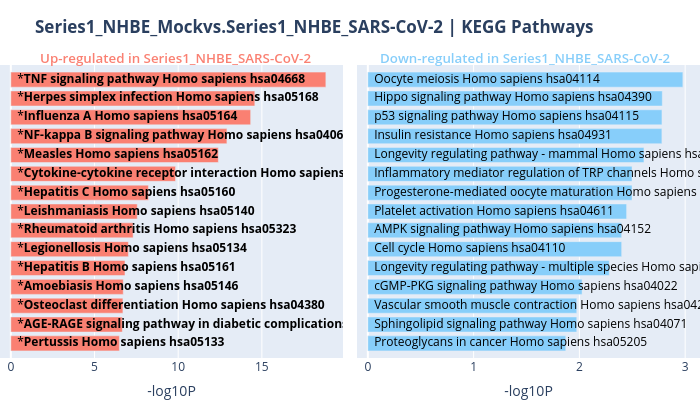

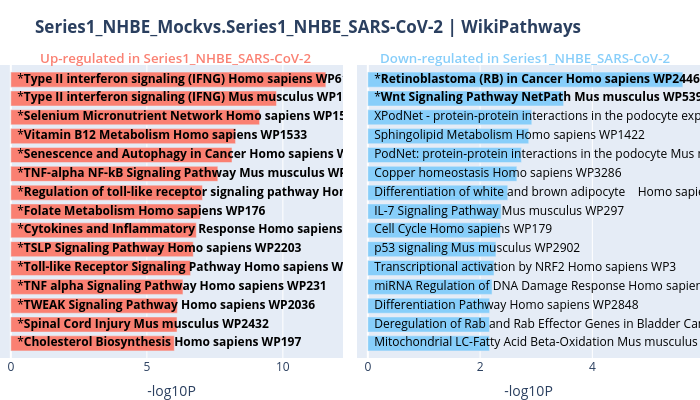

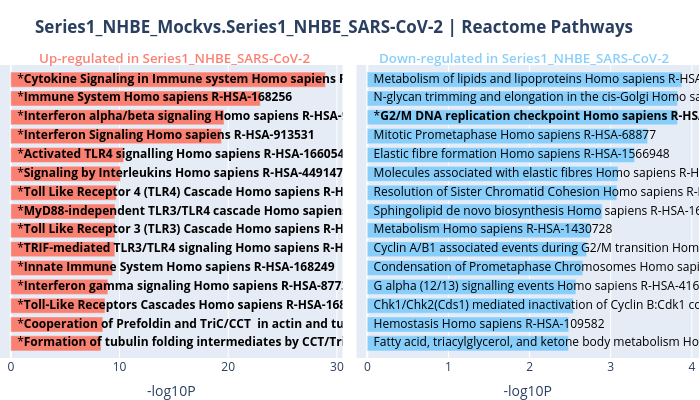

In [38]:
# Initialize results
results['pathway_enrichment'] = {}

# Loop through results
for label, enrichr_results in results['enrichr'].items():
    # Run analysis
    results['pathway_enrichment'][label] = run_pathway(enrichr_results=enrichr_results, signature_label=label, plot_type=plot_type, sort_results_by='pvalue')

for label, signature in signatures.items():
    # Create dataframe
    enrichment_results = results['pathway_enrichment'][label]
    enrichment_dataframe = pd.concat([enrichment_results['upregulated'], enrichment_results['downregulated']])

    # Plot barcharts
    libraries = enrichment_dataframe['gene_set_library'].unique()   
    for gene_set_library in libraries:
        # Display results
        plot_library_barchart(enrichment_results, gene_set_library, enrichment_results['signature_label'], enrichment_results['sort_results_by'], nr_genesets=nr_genesets, plot_type=plot_type)


# 11. Transcription Factor Enrichment Analysis

In [39]:
def run_tf(enrichr_results, signature_label):
    
    # Libraries
    libraries = {
        'ChEA_2016': '### A. ChEA (experimentally validated targets)',
        'ENCODE_TF_ChIP-seq_2015': '### B. ENCODE (experimentally validated targets)',
        'ARCHS4_TFs_Coexp': '### C. ARCHS4 (coexpressed genes)'
    }

    # Initialize results
    results = []

    # Loop through genesets
    for geneset in ['upregulated', 'downregulated']:

        # Append ChEA results
        enrichment_dataframe = get_enrichr_results(enrichr_results[geneset]['userListId'], gene_set_libraries=libraries, geneset=geneset)
        results.append(enrichment_dataframe)

    # Concatenate results
    enrichment_dataframe = pd.concat(results)

    return {'enrichment_dataframe': enrichment_dataframe, 'signature_label': signature_label}

def results_table(enrichment_dataframe, source_label, target_label):

    # Get libraries
    for gene_set_library in enrichment_dataframe['gene_set_library'].unique():

        # Get subset
        enrichment_dataframe_subset = enrichment_dataframe[enrichment_dataframe['gene_set_library'] == gene_set_library].copy()

        # Get unique values from source column
        enrichment_dataframe_subset[source_label] = [x.split('_')[0] for x in enrichment_dataframe_subset['term_name']]
        enrichment_dataframe_subset = enrichment_dataframe_subset.sort_values(['FDR', 'pvalue']).rename(columns={'pvalue': 'P-value'}).drop_duplicates(source_label)

        # Add links and bold for significant results
        enrichment_dataframe_subset[source_label] = ['<a href="http://www.mirbase.org/cgi-bin/query.pl?terms={x}" target="_blank">{x}</a>'.format(**locals()) if '-miR-' in x else '<a href="http://amp.pharm.mssm.edu/Harmonizome/gene/{x}" target="_blank">{x}</a>'.format(**locals())for x in enrichment_dataframe_subset[source_label]]
        enrichment_dataframe_subset[source_label] = [rowData[source_label].replace('target="_blank">', 'target="_blank"><b>').replace('</a>', '*</b></a>') if rowData['FDR'] < 0.05 else rowData[source_label] for index, rowData in enrichment_dataframe_subset.iterrows()]

        # Add rank
        enrichment_dataframe_subset['Rank'] = ['<b>'+str(x+1)+'</b>' for x in range(len(enrichment_dataframe_subset.index))]

        # Add overlapping genes with tooltip
        enrichment_dataframe_subset['nr_overlapping_genes'] = [len(x) for x in enrichment_dataframe_subset['overlapping_genes']]
        enrichment_dataframe_subset['overlapping_genes'] = [', '.join(x) for x in enrichment_dataframe_subset['overlapping_genes']]
        enrichment_dataframe_subset[target_label.title()] = ['{nr_overlapping_genes} {geneset} '.format(**rowData)+target_label+'s' for index, rowData in enrichment_dataframe_subset.iterrows()]
        # enrichment_dataframe[target_label.title()] = ['<span class="gene-tooltip">{nr_overlapping_genes} {geneset} '.format(**rowData)+target_label+'s<div class="gene-tooltip-text">{overlapping_genes}</div></span>'.format(**rowData) for index, rowData in enrichment_dataframe.iterrows()]

        # Convert to HTML
        pd.set_option('max.colwidth', -1)
        html_table = enrichment_dataframe_subset.head(50)[['Rank', source_label, 'P-value', 'FDR', target_label.title()]].to_html(escape=False, index=False, classes='w-100')
        html_results = '<div style="max-height: 200px; overflow-y: scroll;">{}</div>'.format(html_table)

        # Add CSS
        display(HTML('<style>.w-100{width: 100%;} .text-left th{text-align: left !important;}</style>'))
        display(HTML('<style>.slick-cell{overflow: visible;}.gene-tooltip{text-decoration: underline; text-decoration-style: dotted;}.gene-tooltip .gene-tooltip-text{visibility: hidden; position: absolute; left: 60%; width: 250px; z-index: 1000; text-align: center; background-color: black; color: white; padding: 5px 10px; border-radius: 5px;} .gene-tooltip:hover .gene-tooltip-text{visibility: visible;} .gene-tooltip .gene-tooltip-text::after {content: " ";position: absolute;bottom: 100%;left: 50%;margin-left: -5px;border-width: 5px;border-style: solid;border-color: transparent transparent black transparent;}</style>'))

        # Display gene set
        display(Markdown(gene_set_library))

        # Display table
        display(HTML(html_results))

        # Download enrichment results from enrichment_dataframe
        # download_button(enrichment_results.to_csv(sep='\t'), 'Download Enrichment Results', 'enrichment.txt')
        
def display_table(tf_analysis_results):
    
    # Plot Table
    results_table(tf_analysis_results['enrichment_dataframe'].copy(), source_label='Transcription Factor', target_label='target')

    # Download button
    results_dataframe = tf_analysis_results['enrichment_dataframe'].copy()
    results_dataframe['gene_set_library'] = [x.split('. ')[-1] for x in results_dataframe['gene_set_library']]

In [40]:
# Initialize results
results['tf_enrichment'] = {}

# Loop through results
for label, enrichr_results in results['enrichr'].items():
    display(Markdown("## "+label))
    # Run analysis
    results['tf_enrichment'][label] = run_tf(enrichr_results=enrichr_results, signature_label=label)
    display_table(results['tf_enrichment'][label])

## Series1_NHBE_Mockvs.Series1_NHBE_SARS-CoV-2

### A. ChEA (experimentally validated targets)

### B. ENCODE (experimentally validated targets)

### C. ARCHS4 (coexpressed genes)

# 12. Kinase Enrichment Analysis

Protein kinases are enzymes that modify other proteins by chemically adding phosphate groups. Databases such as KEA contain a large number of associations between kinases and their substrates. This information can be leveraged by Enrichr to identify the protein kinases whose substrates are over-represented in the up-regulated and down-regulated genes identified by comparing two groups of samples.

In [41]:
def run_ke(enrichr_results, signature_label):
    # Libraries
    libraries = {
        'KEA_2015': '### A. KEA (experimentally validated targets)',
        'ARCHS4_Kinases_Coexp': '### B. ARCHS4 (coexpressed genes)'
    }

    # Initialize results
    results = []

    # Loop through genesets
    for geneset in ['upregulated', 'downregulated']:

        # Append ChEA results
        enrichment_dataframe = get_enrichr_results(enrichr_results[geneset]['userListId'], gene_set_libraries=libraries, geneset=geneset)
        results.append(enrichment_dataframe)

    # Concatenate results
    enrichment_dataframe = pd.concat(results)

    return {'enrichment_dataframe': enrichment_dataframe, 'signature_label': signature_label}


In [42]:
# Initialize results
results['kinase_enrichment'] = {}

# Loop through results
for label, enrichr_results in results['enrichr'].items():
    display(Markdown("## "+label))
    # Run analysis
    results['kinase_enrichment'][label] = run_ke(enrichr_results=enrichr_results, signature_label=label)

    # Display results
    display_table(results['kinase_enrichment'][label])

## Series1_NHBE_Mockvs.Series1_NHBE_SARS-CoV-2

### A. KEA (experimentally validated targets)

### B. ARCHS4 (coexpressed genes)

# 13. miRNA Enrichment Analysis

microRNAs (miRNAs) are small non-coding RNA molecules which play a key role in the post-transcriptional regulation of gene expression. Databases such as TargetScan and MiRTarBase contain a large number of associations between miRNAs and their targets. This information can be leveraged by Enrichr to identify the miRNAs whose targets are over-represented in the up-regulated and down-regulated genes identified by comparing two groups of samples.

In [43]:
def run_mirna(enrichr_results, signature_label):
    # Libraries
    libraries = {
        'TargetScan_microRNA_2017': '### A. TargetScan (experimentally validated targets)',
        'miRTarBase_2017': '### B. miRTarBase (experimentally validated targets)'
    }

    # Initialize results
    results = []

    # Loop through genesets
    for geneset in ['upregulated', 'downregulated']:

        # Append ChEA results
        enrichment_dataframe = get_enrichr_results(enrichr_results[geneset]['userListId'], gene_set_libraries=libraries, geneset=geneset)
        results.append(enrichment_dataframe)

    # Concatenate results
    enrichment_dataframe = pd.concat(results)

    return {'enrichment_dataframe': enrichment_dataframe, 'signature_label': signature_label}

In [44]:
results['mirna_enrichment'] = {}

# Loop through results
for label, enrichr_results in results['enrichr'].items():
    display(Markdown("## "+label))
    
    # Run analysis
    results['mirna_enrichment'][label] = run_mirna(enrichr_results=enrichr_results, signature_label=label)

    # Display results
    display_table(results['mirna_enrichment'][label])

## Series1_NHBE_Mockvs.Series1_NHBE_SARS-CoV-2

### A. TargetScan (experimentally validated targets)

### B. miRTarBase (experimentally validated targets)

# 14. L1000CDS2 Query

L1000CDS2 is a web-based tool for querying gene expression signatures against signatures created from human cell lines treated with over 20,000 small molecules and drugs for the LINCS project. It is commonly used to identify small molecules which mimic or reverse the effects of a gene expression signature generated from a differential gene expression analysis.

In [45]:
def run_l1000cds2(signature, nr_genes=500, signature_label='', plot_type='interactive'):
    # Define results
    l1000cds2_results = {'signature_label': signature_label}

    # Define upperGenes Function
    upperGenes = lambda genes: [gene.upper() for gene in genes]

    # Get Data
    data = {"upGenes":upperGenes(signature.index[:nr_genes]),"dnGenes":upperGenes(signature.index[-nr_genes:])}

    # Loop through aggravate:
    for aggravate in [True, False]:

        # Send to API
        config = {"aggravate":aggravate,"searchMethod":"geneSet","share":True,"combination":False,"db-version":"latest"}
        r = requests.post('http://amp.pharm.mssm.edu/L1000CDS2/query',data=json.dumps({"data":data,"config":config}),headers={'content-type':'application/json'})
        label = 'mimic' if aggravate else 'reverse'

        # Add results
        resGeneSet = r.json()
        if resGeneSet.get('topMeta'):
            l1000cds2_dataframe = pd.DataFrame(resGeneSet['topMeta'])[['cell_id', 'pert_desc', 'pert_dose', 'pert_dose_unit', 'pert_id', 'pert_time', 'pert_time_unit', 'pubchem_id', 'score', 'sig_id']].replace('-666', np.nan)
            l1000cds2_results[label] = {'url': 'http://amp.pharm.mssm.edu/L1000CDS2/#/result/{}'.format(resGeneSet['shareId']), 'table': l1000cds2_dataframe}
        else:
            l1000cds2_results[label] = None
    l1000cds2_results['plot_type'] = plot_type

    # Return
    return l1000cds2_results
    
def plot_l1000cds2(l1000cds2_results, nr_drugs=7, height=300):

    # Check if there are results
    if not l1000cds2_results['mimic'] or not l1000cds2_results['reverse']:
        display(Markdown('### No results were found.\n This is likely due to the fact that the gene identifiers were not recognized by L1000CDS<sup>2</sup>. Please note that L1000CDS<sup>2</sup> currently only supports HGNC gene symbols (https://www.genenames.org/). If your dataset uses other gene identifier systems, such as Ensembl IDs or Entrez IDs, consider converting them to HGNC. Automated gene identifier conversion is currently under development.'))
    else:
        # Links
        if l1000cds2_results['signature_label']:
            display(Markdown('\n### {signature_label} signature:'.format(**l1000cds2_results)))
        display(Markdown(' **L1000CDS<sup>2</sup> Links:**'))
        display(Markdown(' *Mimic Signature Query Results*: {url}'.format(**l1000cds2_results['mimic'])))
        display(Markdown(' *Reverse Signature Query Results*: {url}'.format(**l1000cds2_results['reverse'])))

        # Bar charts
        fig = tools.make_subplots(rows=1, cols=2, print_grid=False);
        for i, direction in enumerate(['mimic', 'reverse']):
            drug_counts = l1000cds2_results[direction]['table'].groupby('pert_desc').size().sort_values(ascending=False).iloc[:nr_drugs].iloc[::-1]

            # Get Bar
            bar = go.Bar(
                x=drug_counts.values,
                y=drug_counts.index,
                orientation='h',
                name=direction.title(),
                hovertext=drug_counts.index,
                hoverinfo='text',
                marker={'color': '#FF7F50' if direction=='mimic' else '#9370DB'}
            )
            fig.append_trace(bar, 1, i+1)
            
            # Get text
            text = go.Scatter(
                x=[max(bar['x'])/50 for x in range(len(bar['y']))],
                y=bar['y'],
                mode='text',
                hoverinfo='none',
                showlegend=False,
                text=drug_counts.index,
                textposition="middle right",
                textfont={'color': 'black'}
            )
            fig.append_trace(text, 1, i+1)

        fig['layout'].update(height=height, title='<b>L1000CDS<sup>2</sup> | Small Molecule Query</b><br><i>Top small molecules</i>', hovermode='closest')
        fig['layout']['xaxis1'].update(domain=[0,0.5])
        fig['layout']['xaxis1'].update(title='<br>Count')
        fig['layout']['xaxis2'].update(title='<br>Count')
        fig['layout']['xaxis2'].update(domain=[0.5,1])
        fig['layout']['yaxis1'].update(showticklabels=False)
        fig['layout']['yaxis2'].update(showticklabels=False)
        fig['layout']['margin'].update(l=10, t=95, r=0, b=45, pad=5)

        if l1000cds2_results['plot_type'] == 'interactive':
            plotly.offline.iplot(fig)        
        else:
            py.image.ishow(fig)

        # Download
        result_list = []
        for direction, result_dict in l1000cds2_results.items():
            if direction in ['mimic', 'reverse']:
                df = pd.DataFrame(result_dict['table'])
                df['direction'] = direction
                result_list.append(df)
        result_txt = pd.concat(result_list).to_csv(index=False, sep='\t')

## Series1_NHBE_Mockvs.Series1_NHBE_SARS-CoV-2


### Series1_NHBE_Mockvs.Series1_NHBE_SARS-CoV-2 signature:

 **L1000CDS<sup>2</sup> Links:**

 *Mimic Signature Query Results*: http://amp.pharm.mssm.edu/L1000CDS2/#/result/5e9a0617b319db0042467783

 *Reverse Signature Query Results*: http://amp.pharm.mssm.edu/L1000CDS2/#/result/5e9a0617b319db0042467785

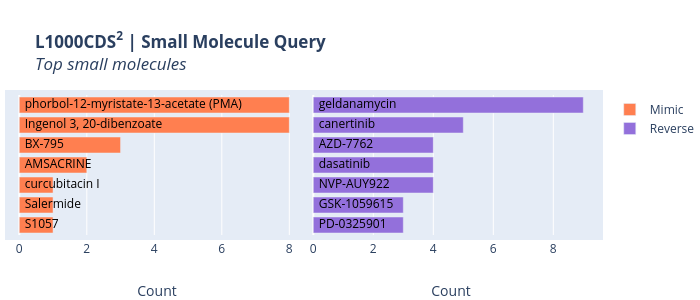

In [46]:
# Initialize results
results['l1000cds2'] = {}

# Loop through signatures
for label, signature in signatures.items():
    display(Markdown("## "+label))
    
    # Run analysis
    results['l1000cds2'][label] = run_l1000cds2(signature=signature, nr_genes=l1000_topk, signature_label=label, plot_type=plot_type)

    # Display results
    plot_l1000cds2(results['l1000cds2'][label], nr_drugs=nr_drugs)

# 15. L1000FWD Query

L1000FWD is a web-based tool for querying gene expression signatures against signatures created from human cell lines treated with over 20,000 small molecules and drugs for the LINCS project.

In [47]:
def run_l1000fwd(signature, nr_genes=500, signature_label=''):
    # Define results
    l1000fwd_results = {'signature_label': signature_label}

    # Define upperGenes Function
    upperGenes = lambda genes: [gene.upper() for gene in genes]

    # Get Data
    payload = {"up_genes":upperGenes(signature.index[:nr_genes]),"down_genes":upperGenes(signature.index[-nr_genes:])}

    # Get URL
    L1000FWD_URL = 'https://amp.pharm.mssm.edu/L1000FWD/'

    # Get result
    response = requests.post(L1000FWD_URL + 'sig_search', json=payload)
    if 'KeyError' in response.text:
        l1000fwd_results['result_url'] = None
    else:
        # Get ID and URL
        result_id = response.json()['result_id']
        l1000fwd_results['result_url'] = 'https://amp.pharm.mssm.edu/l1000fwd/vanilla/result/'+result_id
        l1000fwd_results['result_id'] = result_id

        # Get Top
        l1000fwd_results['signatures'] = requests.get(L1000FWD_URL + 'result/topn/' + result_id).json()


    # Return
    return l1000fwd_results
    
def plot_l1000fwd(l1000fwd_results, nr_drugs=7, height=300):
    
    # Check if results
    if l1000fwd_results['result_url']:

        # Display IFrame
        display(IFrame(l1000fwd_results['result_url'], width="1000", height="1000"))

        # Display tables
        for direction, signature_list in l1000fwd_results['signatures'].items():

            # Fix dataframe
            rename_dict = {'sig_id': 'Signature ID', 'pvals': 'P-value', 'qvals': 'FDR', 'zscores': 'Z-score', 'combined_scores': 'Combined Score'}
            signature_dataframe = pd.DataFrame(signature_list)[list(rename_dict.keys())].rename(columns=rename_dict).sort_values('P-value').rename_axis('Rank')
            signature_dataframe.index = [x + 1 for x in range(len(signature_dataframe.index))]
            signature_txt = signature_dataframe.to_csv(sep='\t')

            # Display table
            pd.set_option('max.colwidth', -1)
            signature_dataframe['Signature ID'] = ['<a href="http://amp.pharm.mssm.edu/dmoa/sig/{x}" target="_blank">{x}</a>'.format(**locals()) for x in signature_dataframe['Signature ID']]
            table_html = signature_dataframe.to_html(escape=False, classes='w-100')
            display(Markdown('** {} Signatures: **'.format(direction.title())))
            display(HTML('<style>.w-100{{width: 100% !important;}}</style><div style="max-height: 250px; overflow-y: auto; margin-bottom: 25px;">{}</div>'.format(table_html)))


In [48]:
# Initialize results
results['l1000fwd'] = {}

# Loop through signatures
for label, signature in signatures.items():
    display(Markdown("## "+label))
    
    # Run analysis
    results['l1000fwd'][label] = run_l1000fwd(signature=signature, signature_label=label, nr_genes=l1000_topk)

    # Display results
    plot_l1000fwd(results['l1000fwd'][label])

## Series1_NHBE_Mockvs.Series1_NHBE_SARS-CoV-2

** Similar Signatures: **

** Opposite Signatures: **